In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from trainmodel import prepare_input_data, compute_class_weights
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

2024-04-09 19:05:14.390270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data_path = 'train_data.csv'
test_data_path = 'test_data.csv'

# Prepare the input data and compute class weights
X_train, y_train, X_test, y_test, word_index = prepare_input_data(train_data_path, test_data_path)
class_weights = compute_class_weights(y_train)


In [3]:
def define_lstm_model(vocab_size, embedding_dim=64, lstm_units=128):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        LSTM(units=lstm_units),
        Dropout(0.3),  # Increased dropout
        Dense(units=50, activation='relu', kernel_regularizer=l2(0.001)),  # Added L2 regularization
        Dropout(0.3),  # Increased dropout
        Dense(units=3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(word_index) + 1  # Plus one for padding token
model = define_lstm_model(vocab_size)

In [4]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=64, 
                    class_weight=class_weights, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

Epoch 1/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 235s 121ms/step - accuracy: 0.5106 - loss: 1.0848 - val_accuracy: 0.2512 - val_loss: 1.1037
Epoch 2/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 233s 121ms/step - accuracy: 0.6676 - loss: 0.9160 - val_accuracy: 0.7601 - val_loss: 0.5730
Epoch 3/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 236s 122ms/step - accuracy: 0.7870 - loss: 0.6092 - val_accuracy: 0.7966 - val_loss: 0.4764
Epoch 4/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 239s 124ms/step - accuracy: 0.8108 - loss: 0.5270 - val_accuracy: 0.7891 - val_loss: 0.4917
Epoch 5/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 234s 121ms/step - accuracy: 0.8317 - loss: 0.4721 - val_accuracy: 0.7814 - val_loss: 0.5056
Epoch 6/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 229s 119ms/step - accuracy: 0.8513 - loss: 0.4210 - val_accuracy: 0.7875 - val_loss: 0.5135


965/965 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7981 - loss: 0.4744
Test Loss: 0.47634175419807434
Test Accuracy: 0.7965524792671204


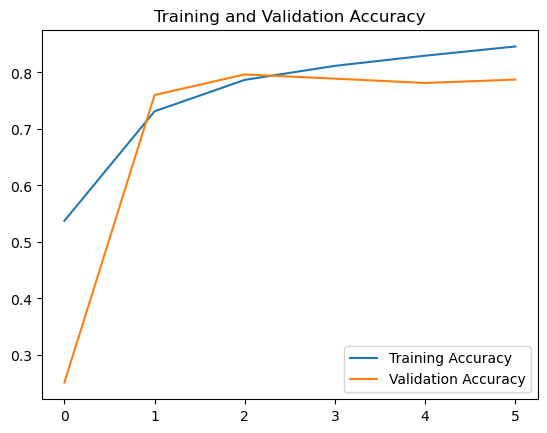

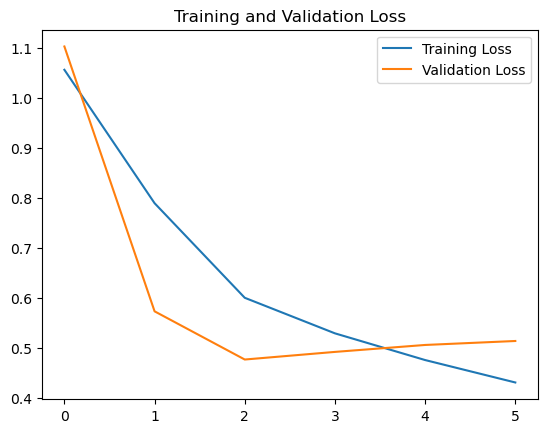

In [5]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
